# 10 Ordinary differential equations – Integrators
More about integrators to solve ODEs.

* Euler's Rule (and it's shortcomings) 
* Runge-Kutta methods

## Euler's Rule

From the last lecture: Given the $n$-dimensional vectors from the ODE standard form

$$
\frac{d\mathbf{y}}{dt} = \mathbf{f}(t, \mathbf{y})
$$
the **Euler rule** amounts to

\begin{align}
\mathbf{f}(t, \mathbf{y}) = \frac{d\mathbf{y}(t)}{dt} &\approx \frac{\mathbf{y}(t_{n+1}) - \mathbf{y}(t_n)}{h}\\
\mathbf{y}_{n+1} &\approx \mathbf{y}_n + h \mathbf{f}(t_n, \mathbf{y}_n) \quad \text{with} \quad \mathbf{y}_n := \mathbf{y}(t_n)
\end{align}

Euler's rule cannot obtain high precision without very small $h$ but this leads to higher round-off error accumulation.

### Euler's Rule applied to the 1D harmonic oscillator (theory)

\begin{alignat}{3}
f^{(0)}(t, \mathbf{y}) &= y^{(1)},
    &\quad y^{(0)}_0 &= x_0,\\
f^{(1)}(t, \mathbf{y}) &=   - \frac{k}{m} y^{(0)},
    &\quad y^{(1)}_0 &= v_0.
\end{alignat}

with $k=1$; $x_0 = 0$ and $v_0 = +1$.

First step from $t=0$ to $t=h$:

\begin{align}
y^{(0)}_1 &= y^{(0)}_0 + h y^{(1)}_0 = x_0 + v_0 h\\
y^{(1)}_1 &= y^{(1)}_0 + h \left(-\frac{k}{m}y^{(0)}_0\right) = v_0 + \frac{-k x_0}{m} h 
\end{align}

Compare to the equations of movement under a constant force (*ballistic motion*):

$$
x = x_0 + v_0 h + \frac{1}{2} a h^2, \quad v = v_0 + a h
$$

In Euler, the position does not even contain the $h^2$ term, i.e., the acceleration only contributes *indirectly* via the velocity of the *next* step. (Remember: Euler's error is $\mathcal{O}(h^2)$!)

### Euler's Rule: Application to 3 oscillators (numerical)
`git pull` new resources.

Put the notebook `10-ODE_integrators-students.ipynb` *and* the module `integrators.py` into the same directory, for instance a work directory `~/PHY494/10_ODEs`.

Open [integrators.py](https://github.com/ASU-CompMethodsPhysics-PHY494/PHY494-resources/blob/master/10_ODEs/integrators.py) to have a look at it: it contains code to integrate Newton's equations of motions for different forces and with different integrators (based on the work done in the last lecture).

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

import integrators_solution as integrators

In [2]:
t_max = 20
t_harm, y_harm = integrators.integrate_newton(t_max=t_max)
t_anharm, y_anharm = integrators.integrate_newton(t_max=t_max, 
                                                  force=integrators.F_anharmonic)
t_power, y_power = integrators.integrate_newton(t_max=t_max,
                                                force=integrators.F_power)

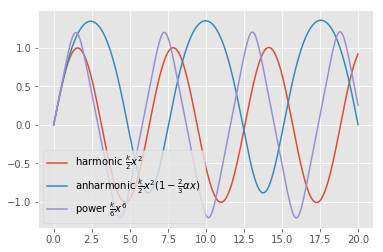

In [3]:
plt.plot(t_harm, y_harm[:, 0], label=r"harmonic $\frac{k}{2} x^2$")
plt.plot(t_anharm, y_anharm[:, 0], label=r"anharmonic $\frac{k}{2} x^2(1 - \frac{2}{3} \alpha x)$")
plt.plot(t_power, y_power[:, 0], label=r"power $\frac{k}{6} x^6$")
plt.legend(loc="best")

#### Phase-space portrait
Plot position against momentum ($x, p$):

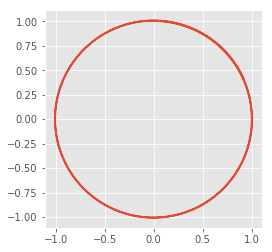

In [4]:
m = 1
x = y_harm[:, 0]
p = m * y_harm[:, 1]
ax = plt.subplot(1,1,1)
ax.plot(x, p)
ax.set_aspect(1)

In [5]:
t, y = integrators.integrate_newton(t_max=40, 
                                    force=integrators.F_harmonic, 
                                    h=0.01)
t2, y2 = integrators.integrate_newton(t_max=40, h=0.001,
                                      force=integrators.F_harmonic)

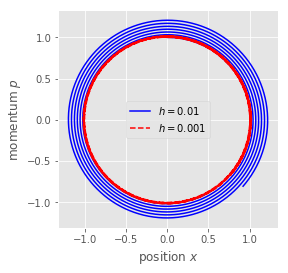

In [6]:
ax = plt.subplot(1,1,1)
ax.plot(y[:, 0], m * y[:, 1], 'b-', label=r"$h=0.01$")
ax.plot(y2[:, 0], m * y2[:, 1], 'r--', label="$h=0.001$")
ax.set_xlabel("position $x$")
ax.set_ylabel("momentum $p$")
ax.set_aspect(1)
ax.legend(loc="best")

#### Energy
Energy is conserved: stringent test for the integrator!

$$
E = T_\text{kin} + U\\
\frac{dE}{dt} = 0
$$
with $T_\text{kin} = \frac{1}{2} m v^2$.

Calculate and plot the three energy terms:

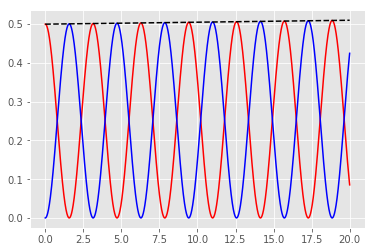

In [7]:
KE = 0.5 * m * y_harm[:, 1]**2
PE = integrators.U_harmonic(y_harm[:, 0])
energy = KE + PE
plt.plot(t_harm, KE, 'r-', t_harm, PE, 'b-', t_harm, energy, 'k--')

Harmonic oscillator with larger timestep $h=0.01$

In [8]:
m = 1
t, y = integrators.integrate_newton(t_max=500, force=integrators.F_harmonic, h=0.01, mass=m)
x, v = y.T
KE = 1/2 * m * v**2
PE = integrators.U_harmonic(x)
energy = KE + PE

Text(0.5,1,'Euler: harmonic oscillator')

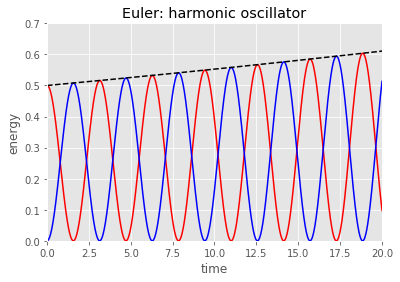

In [9]:
ax = plt.subplot(1,1,1)
ax.plot(t, KE, 'r-', t, PE, 'b-', t, energy, 'k--')
ax.set_xlim(0, 20)
ax.set_ylim(0, 0.7)
ax.set_xlabel("time")
ax.set_ylabel("energy")
ax.set_title("Euler: harmonic oscillator")

Note how energy conservation becomes worse when $h$ is increased.

For longer time scales, the energy just keeps on increasing — clearly, we are not solving the equations of motions in a physically meaningful way.

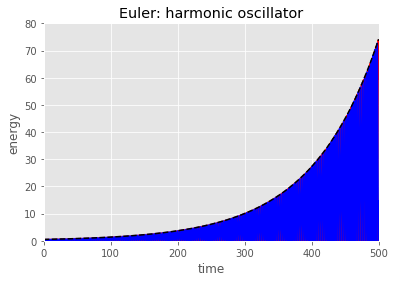

In [10]:
ax.set_ylim(0, 80)
ax.set_xlim(0,500)
ax.figure

##### Quantify energy drift
Measure the relative departure from energy conservation

$$
\epsilon_E(t) = \log_{10}\left|\frac{E(t) - E(t=0)}{E(t=0)}\right|
$$

(By using the decadic logarithm, $-\epsilon_E$ is a direct measure of the precision.)

###### Harmonic oscillator
Analyze energy drift for the last harmonic oscillator example ($h=0.01$):

/Users/oliver/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


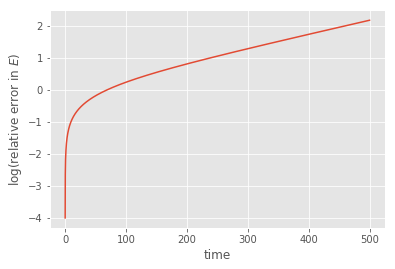

In [13]:
energy_precision = np.log10(np.abs(energy/energy[0] - 1))
plt.plot(t, energy_precision)
plt.ylabel("log(relative error in $E$)")
plt.xlabel("time");

As we already know, with such a large time step, energy conservation is very bad with the *Euler* integrator: The relative (!) error quickly becomes 100% (after $t=200$).

##### Code re-use: energy analysis as a function
The module `integrators` contains the function `integrators.analyze_energies(t, y, U)` to automate the task of analysing the energy. You *must* provide the appropriate potential energy function `U`.

##### Problem: Make `analyze_energies()` work and analyze the power law oscillator
The code is *incomplete*.
1. Open `integrators.py` in your editor.
2. Complete the `kinetic_energy()` function (remember: $T_\text{kin} = \frac{1}{2} m v^2$)

Then `reload()` the module:

In [12]:
# when working on the integrator module you need to reload() whenever you make changes
from importlib import reload   # for Python 3
reload(integrators);

and try it out for power law oscillator with a large time step $h = 0.01$. Can you find a value of $h$ that will give you energy precision to 4th decimal over 40 time units?

###### Energy stability analysis of the 6-th power oscillator
$x^6$ potential with $h=0.01$:

In [14]:
t, y = integrators.integrate_newton(t_max=40, force=integrators.F_power, 
                                    h=0.01)

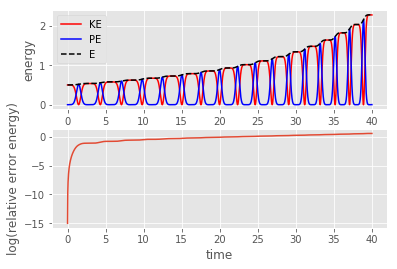

In [15]:
integrators.analyze_energies(t, y, integrators.U_power)

Trying 100 times smaller $h$ (takes 100 times longer!!)

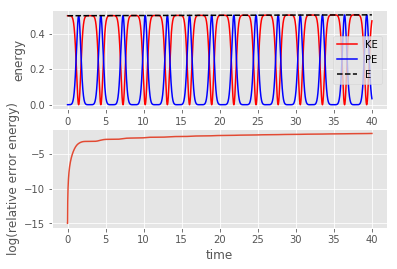

In [16]:
t, y = integrators.integrate_newton(t_max=40, force=integrators.F_power, 
                                    h=0.0001)
integrators.analyze_energies(t, y, integrators.U_power)

*Reducing $h$ further does not seem to help and takes order of magnitude longer to run*. **We need a better integrator!**

## Runge-Kutta methods
Explicit RK methods propagate with the general form

$$
y_{n+1} = y_n + h \sum_{i=1}^s b_i k_i, \quad t_{n+1} = t_n + h
$$

where $s$ is the number of *stages* and the coefficients $a_{ij}$, $b_i$ and $c_i$ define the method.

\begin{align}
k_1 &= f(t_n, y_n)\\
k_2 &= f(t_n + c_2 h, y_n + h(a_{21} k_1))\\
k_3 &= f(t_n + c_3 h, y_n + h(a_{31} k_1 + a_{32} k_2))\\
 \vdots& \\
k_s &= f(t_n + c_s h, y_n + h(a_{s1} k_1 + a_{s2} k_2 + \cdots + a_{s,s-1} k_{s-1})). 
\end{align}

Basic idea: improve estimate for the slope by using weighted averages of slopes over the interval.

### RK4
General purpose ODE solver.

$$
y_{n+1} = y_n + \frac{h}{6}\Big(k_1 + 2 k_2 + 2 k_3 + k_4\Big), \quad t_{n+1} = t_n + h
$$

and

\begin{align}
k_1 &= f(t_n, y_n)\\
k_2 &= f(t_n + \frac{1}{2} h, y_n + \frac{1}{2} h k_1)\\
k_3 &= f(t_n + \frac{1}{2} h, y_n + \frac{1}{2} h k_2)\\
k_4 &= f(t_n + h, y_n + h k_3)
\end{align}

`rk4` can obtain $\mathcal{O}(h^4)$ precision.

### RK2
`rk2` is simpler to derive and understand than `rk4` (which we will use more often).

Start with the exact solution

$$
\frac{dy}{dt} = f(t, y) \quad\text{and}\quad y(t) = \int f(t, y)dt\\
y_{n+1} = y_n + \int_{t_n}^{t_{n+1}} f(t, y)dt
$$

Expand $f(t, y)$ around *midpoint* $t_{n+1/2} = t + \frac{h}{2}$ of integration interval

\begin{gather}
f(t, y) \approx f(t_{n+1/2}, y_{n+1/2}) + (t - t_{n+1/2})\,  f^{(1)}(t_{n+1/2}) + 
   \mathcal{O}(h^2)
\end{gather}

Integrate the *expansion* (Taylor series around midpoint):
\begin{align}
\int_{t_n}^{t_{n+1}} f(t, y) \, dt &\approx h\, f(t_{n+1/2}, y_{n+1/2}) + \mathcal{O}(h^3)\\
y_{n+1} &= y_n + h\, f(t_{n+1/2}, y_{n+1/2}) + \mathcal{O}(h^3)
\end{align}

I.e., use **slope at midpoint**! (The $\mathcal{O}(h^2)$ term in the integral is zero because $[(h/2)^2 - (h/2)^2] = 0$.)

But we don't have $y_{n+1/2}$ so we use Euler's rule to estimate it to $\mathcal{O}(h^2)$:

$$
y_{n+1/2} \approx y_n + \frac{1}{2} h\, f(t_n, y_n)
$$

and insert into $y_{n+1} = y_n + h\, f(t_{n+1/2}, y_{n+1/2})$ (so it is still $\mathcal{O}(h^3)$ accurate).


Altogether: **RK2** algorithm

$$
\mathbf{y}_{n+1} = \mathbf{y}_n + h \mathbf{k}_2, \quad t_{n+1} = t_n + h
$$

and

\begin{align}
\mathbf{k}_1 &= \mathbf{f}(t_n, \mathbf{y}_n)\\
\mathbf{k}_2 &= \mathbf{f}(t_n + \frac{1}{2} h, \mathbf{y}_n + \frac{1}{2} h \mathbf{k}_1)
\end{align}

with $\mathcal{O}(h^3)$ accuracy.

#### RK2 applied to the 1D harmonic oscillator (theory)

\begin{alignat}{3}
f^{(0)}(t, \mathbf{y}) &= y^{(1)},
    &\quad y^{(0)}_0 &= x_0,\\
f^{(1)}(t, \mathbf{y}) &=   - \frac{k}{m} y^{(0)},
    &\quad y^{(1)}_0 &= v_0.
\end{alignat}

with $k=1$; $x_0 = 0$ and $v_0 = +1$.

First step from $t=0$ to $t=h$:

\begin{align}
  y^{(0)}_{1} &= 
    y^{(0)} _{0} + hf^{(0)} \Big(\frac{h}{2}, y^{(0)}_{0} + hk_{1} \Big)\\
    &= x_{0} + h\left[v_{0} + \frac{h}{2} \left(-\frac{k}{m} x_{0}\right)  \right]\\
    &= x_0 + v_0 h + \frac{1}{2} \left(-\frac{k}{m} x_{0}\right) h^2\\
  y^{(1)}_{1} &= y^{(1)}_{0} + 
                h f^{(1)}\left(\frac{h}{2}, 
                     \mathbf{y}_{0} + \frac{h}{2} \mathbf{f}(0, \mathbf{y}_{0})\right) \\
             &= v_{0} + \frac{h}{m} \left[-k\left(x_{0} - \frac{h}{2} k x_{0}\right)\right]
\end{align}

Note that `rk2` contains a $h^2$ term in the position update.

#### RK2 applied in practice 
Let's implement `rk2` 

\begin{align}
\mathbf{y}_{n+1} &= \mathbf{y}_n + h \mathbf{k}_2\\
\mathbf{k}_1 &= \mathbf{f}(t_n, \mathbf{y}_n)\\
\mathbf{k}_2 &= \mathbf{f}(t_n + \frac{1}{2} h, \mathbf{y}_n + \frac{1}{2} h \mathbf{k}_1)
\end{align}

in our `integrators.py`.

In [16]:
from importlib import reload
reload(integrators);

##### RK2 for the power potential

In [17]:
t, y = integrators.integrate_newton(t_max=40, force=integrators.F_power, 
                                    integrator=integrators.rk2, h=0.01)

###### phase-space portrait

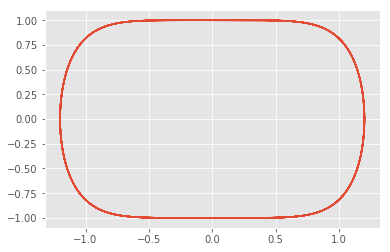

In [18]:
plt.plot(y[:, 0], m*y[:, 1])

###### energy drift 

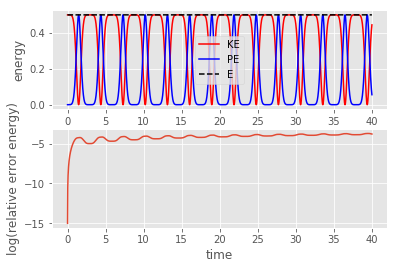

In [19]:
integrators.analyze_energies(t, y, integrators.U_power)

#### RK4 applied in practice
Implement `rk4` in `integrator.py`:

\begin{align}
y_{n+1} &= y_n + \frac{h}{6}\Big(k_1 + 2 k_2 + 2 k_3 + k_4\Big)\\
k_1 &= f(t_n, y_n)\\
k_2 &= f(t_n + \frac{1}{2} h, y_n + \frac{1}{2} h k_1)\\
k_3 &= f(t_n + \frac{1}{2} h, y_n + \frac{1}{2} h k_2)\\
k_4 &= f(t_n + h, y_n + h k_3)
\end{align}

In [20]:
reload(integrators)

<module 'integrators_solution' from '/Volumes/Data/oliver/Documents/Teaching/ASU/CompPhys_PHY494/2018/PHY494-resources/10_ODEs/integrators_solution.py'>

and test the 6th power potential again. What level of energy precision can you obtain over 40 time units?

##### RK4 for the 6th power potential
Note that we can easily run `rk4` with a $h=0.01$!

In [20]:
t, y = integrators.integrate_newton(t_max=40, force=integrators.F_power, 
                                    integrator=integrators.rk4, h=0.01)

###### phase-space protrait

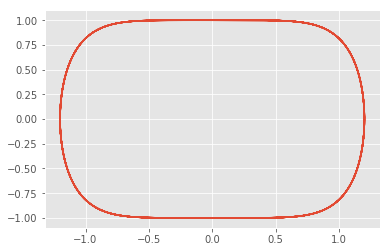

In [21]:
plt.plot(y[:, 0], m*y[:, 1])

###### energy drift

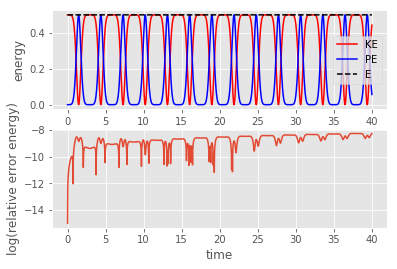

In [22]:
integrators.analyze_energies(t, y, integrators.U_power)

You should be able to get 8 - 11 decimals precision from `rk4` with a smaller $h$.

##### High precision RK4 for the 6th power potential
Try a 10 times smaller step $h=0.001$

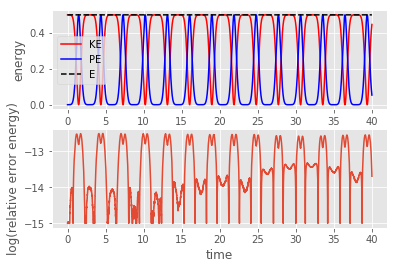

In [23]:
t, y = integrators.integrate_newton(t_max=40, force=integrators.F_power, 
                                    integrator=integrators.rk4, h=0.001)
integrators.analyze_energies(t, y, integrators.U_power)

This looks like stable integration with an error of not worse than $10^{-12}$: *Looking very good!* (Especially when you compare it to *Euler* with $h=0.001$!)

The error spikes when the potential energy is dominant, which happens near the classical turning points where (in this case) the potential is the steepest and the forces are highest.